In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import scipy.ndimage as ndi
import scipy.signal as ss
import skimage.filters as sf
from skimage.morphology import disk
from sklearn import mixture
import itertools
import os, sys

In [2]:
def cluster_by_gaussian(_X, n_cluster=2, seed=None, verbose=False):

    _X = np.expand_dims(_X, -1)

    if seed != 'None':
        np.random.seed(seed)

    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, n_cluster + 1)
    cv_types = ["spherical", "tied", "diag", "full"]
    for cv_type in cv_types:
        for n_components in n_components_range:
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(_X)
            bic.append(gmm.bic(_X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    color_iter = itertools.cycle(['black', 'purple', 'blue', 'green', 'gold', 'orange', 'red', 'pink', 'brown', 'grey'])
    # color_iter = itertools.cycle(['Greys_r', 'Purples_r', 'Blues_r', 'Greens_r', 'Oranges_r', 'Reds_r'])
    clf = best_gmm

    _Y = clf.predict(_X)

    if verbose:
        for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
            if not np.any(_Y == i):
                continue
            # plot_2D_hist(_X[_Y == i, 0], _X[_Y == i, 1], colormap=color)
            plt.scatter(_X[_Y == i, 0], _X[_Y == i, 1], s=0.2, color=color)

    return _Y

def Find_Intensity_Peaks(_z, bins=50, normalized_height=0.2, filter_width_coef=2, pad_left=True, pad_right=True, peak_choice=-1, verbose=False):

    _h, _b = np.histogram(_z, bins=bins)
    _h = _h / _h.max()
    _db = _b[1] - _b[0]

    if pad_left:
        _b = np.concatenate(([_b[0] - _db], _b))
        _h = np.concatenate(([0], _h))

    if pad_right:
        _b = np.concatenate((_b, [_b[-1] + _db]))
        _h = np.concatenate((_h, [0]))

    _b = _b[:-1]/2 + _b[1:]/2

    _hs = ndi.gaussian_filter(_h, sigma=filter_width_coef*(_b.max() - _b.min()))
    _peaks, _ = ss.find_peaks(_hs, height=normalized_height)

    if len(_peaks) > 1:
        _Y = cluster_by_gaussian(_z, n_cluster=len(_peaks))
        _labels = np.unique(_Y)

        _means = np.zeros([len(_labels), 2])
        for i in _labels:
            _means[i] = [i, np.mean(_z[_Y == i])]
        
        df_ints = pd.DataFrame(_means, columns=['group', 'mean']).sort_values(by='mean')
        
        _z = _z[_Y == df_ints['group'].iloc[peak_choice]]

    _h_, _b_ = np.histogram(_z, bins=bins)
    _b_ = _b_[:-1] / 2 + _b_[1:] / 2
    _h_ = _h_ / _h_.max()
    u_ = np.sum(_b_ * _h_) / np.sum(_h_)
    n_ = len(_h_[_h_ > 0])
    m_ = ((n_ - 1) / n_)
    s_ = np.sqrt(np.sum(_h_ * (u_ - _b_) ** 2) / (m_ * np.sum(_h_)))
    r_min_ = u_ - s_
    r_max_ = u_ + s_

    if verbose:

        plt.plot(_b, _h, '.-', c='grey')
        plt.plot(_b_, _h_, '.-', c='black')
        plt.plot(_b, _hs, c='red')
        plt.plot(_b[_peaks], _hs[_peaks], 'x', c='green')
        plt.plot([r_min_, r_min_], [_h.min(), _h.max()], c='red')
        plt.plot([r_max_, r_max_], [_h.min(), _h.max()], c='red')

        plt.show()

    return np.array([r_min_, r_max_]), _b[_peaks]

def Erode_Cell(_crop, deg=3):

    eroded = sf.rank.minimum(np.array(_crop, dtype=int), footprint=disk(deg))

    return eroded

def Make_Album_50(_df, _channel, _range_log10, _path_name):
    
    _df_album = _df.copy()    
    _df_album = _df_album[_df_album[_channel] >= 10**_range_log10[0]]
    _df_album = _df_album[_df_album[_channel] <= 10**_range_log10[1]]
    print('Cells:', len(_df_album))

    if len(_df_album) > 50:
        _df_album = _df_album.sample(n=50, random_state=2023)

    for _c, _file in enumerate(_df_album['image']):


        _img = np.moveaxis(np.array(Image.open(os.path.join(_path_name, _file)).resize((128, 128)), dtype=float), -1, 0)
        _mask = _img[2] > 0
        # mask = Erode_Cell(mask, deg=6)
        _img_final = _img[0]*_mask
        plt.subplot(5, 10, _c + 1)
        plt.imshow(_img_final, cmap='Greys_r')
        plt.axis('off')

In [3]:
df_raw = pd.read_csv(os.path.join('', 'Cells_Imaged.csv'))
print(df_raw.shape)

(743328, 38)


In [4]:
print(len(np.unique(df_raw['gene'])))

df = df_raw[df_raw['gene'] != 'non-targeting-control']
df_NTC = df_raw[df_raw['gene'] == 'non-targeting-control']
      
print(len(np.unique(df['gene'])))
print(len(np.unique(df_NTC['gene'])))

61
60
1


0it [00:00, ?it/s]

---------------------------------------
0 . mNG2_60_AATF_N_-26


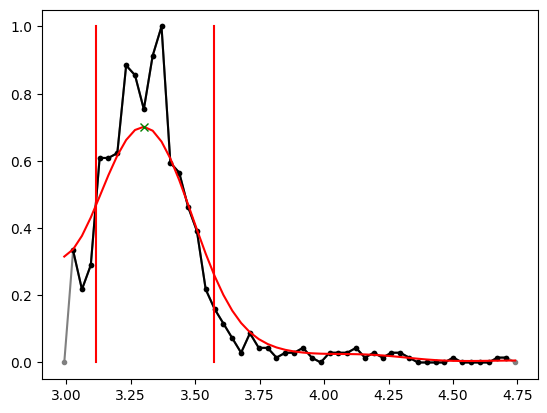

1it [00:00,  4.20it/s]

---------------------------------------
1 . mNG2_60_AATF_N_0


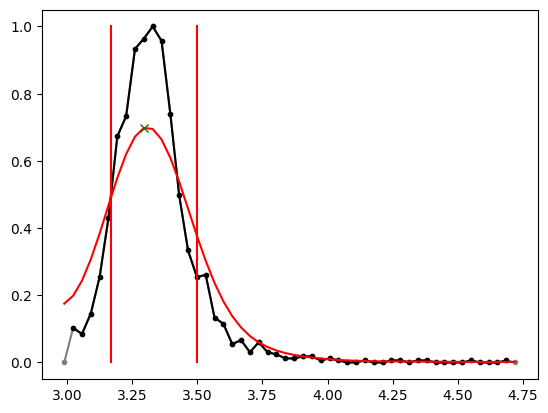

2it [00:00,  4.97it/s]

---------------------------------------
2 . mNG2_60_ACTB_N_-27


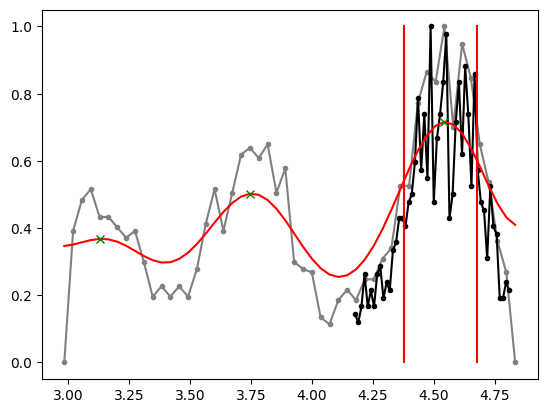

Cells: 648


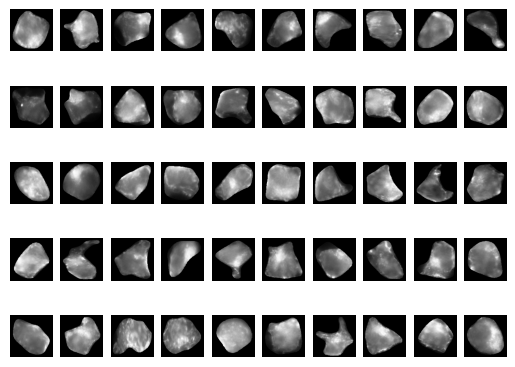

3it [00:02,  1.02it/s]

---------------------------------------
3 . mNG2_60_ACTB_N_-5


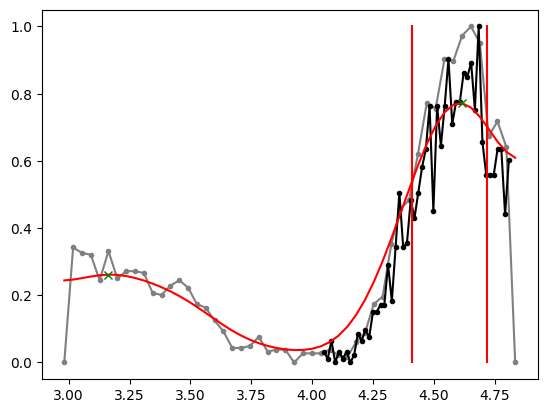

Cells: 1313


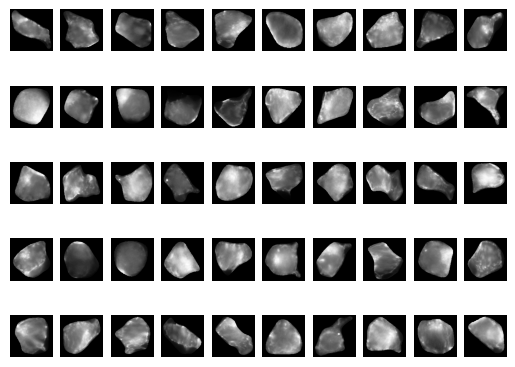

4it [00:03,  1.20s/it]

---------------------------------------
4 . mNG2_60_ACTB_N_1


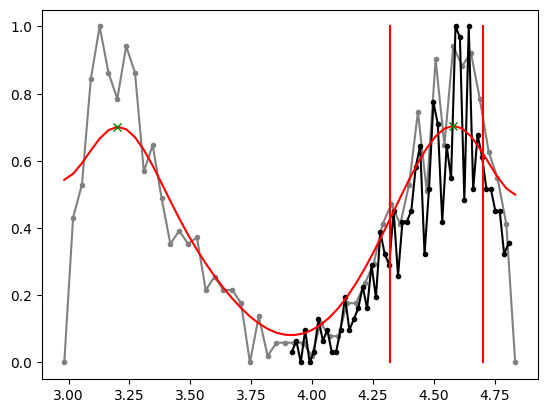

Cells: 385


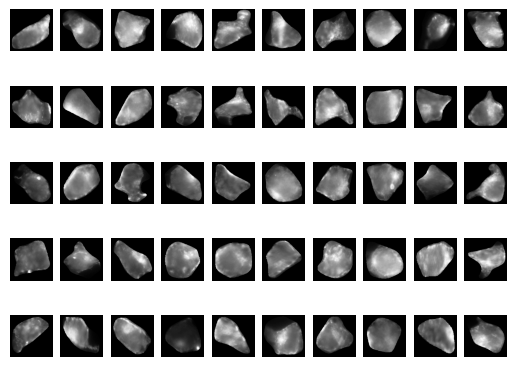

5it [00:05,  1.42s/it]

---------------------------------------
5 . mNG2_60_ACTB_N_19


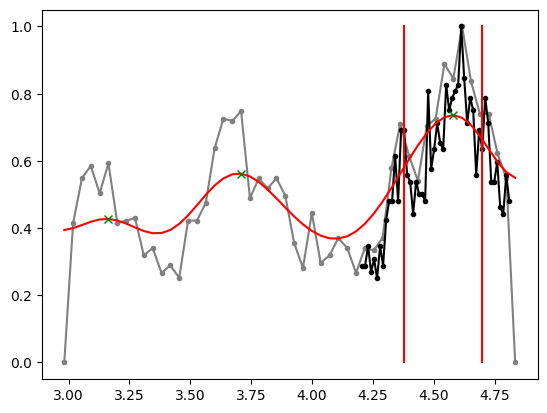

Cells: 921


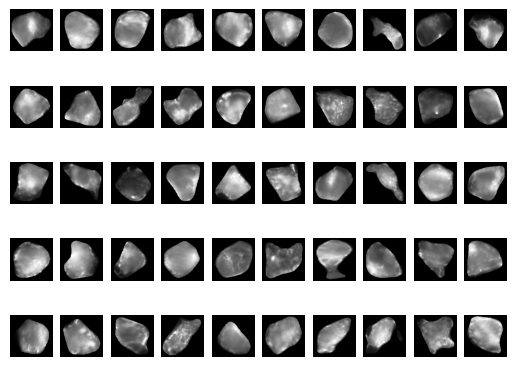

6it [00:08,  1.81s/it]

---------------------------------------
6 . mNG2_60_ARFIP2_C_-11


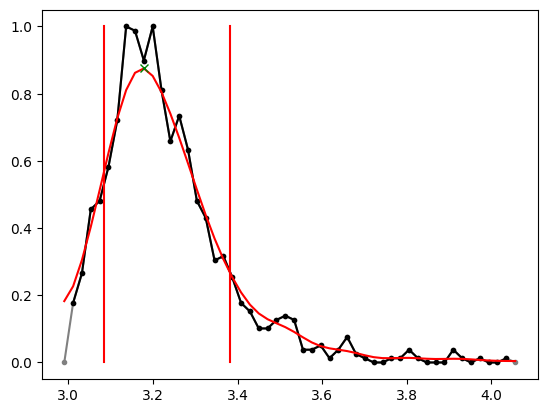

7it [00:08,  1.27s/it]

---------------------------------------
7 . mNG2_60_ARFIP2_C_20


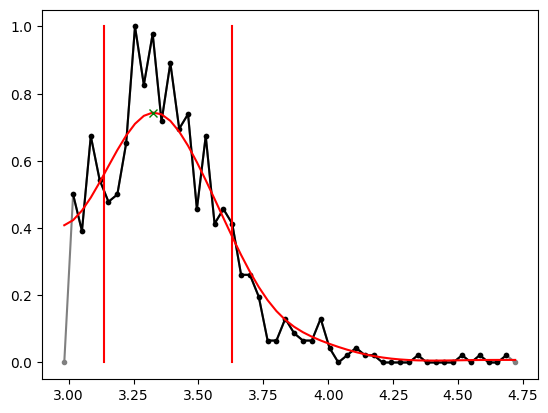

8it [00:08,  1.09it/s]

---------------------------------------
8 . mNG2_60_BAIAP2L1_N_-17


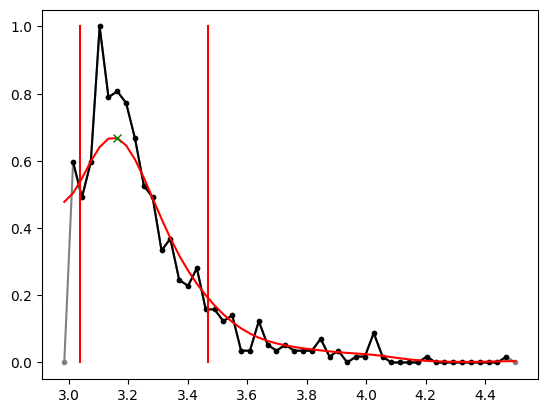

9it [00:08,  1.46it/s]

---------------------------------------
9 . mNG2_60_BCAP31_C_-11


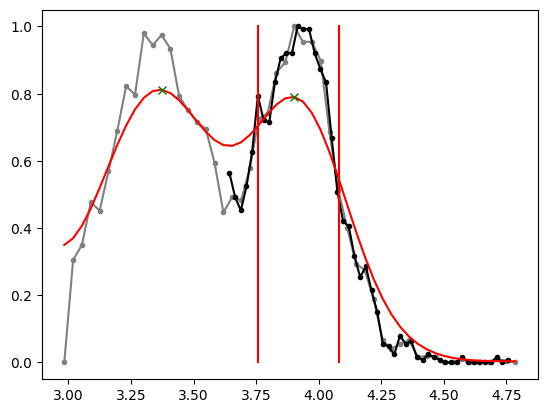

Cells: 1530


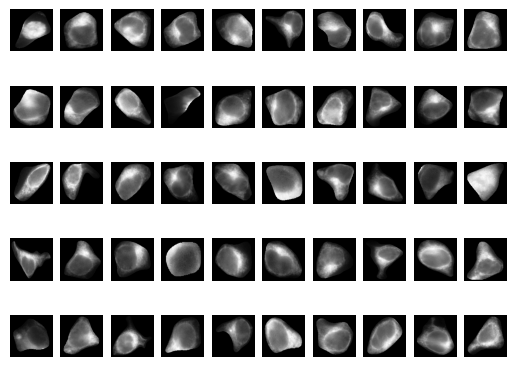

10it [00:11,  1.33s/it]

---------------------------------------
10 . mNG2_60_BCAP31_C_-20


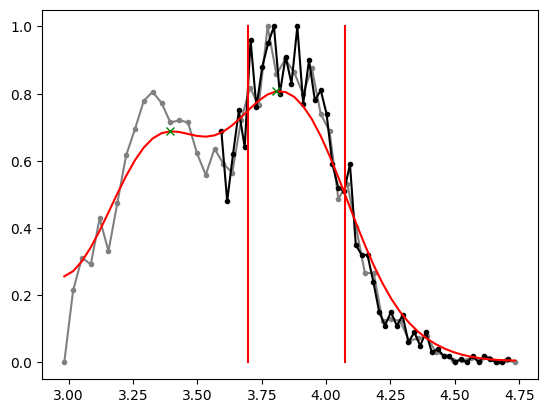

Cells: 1346


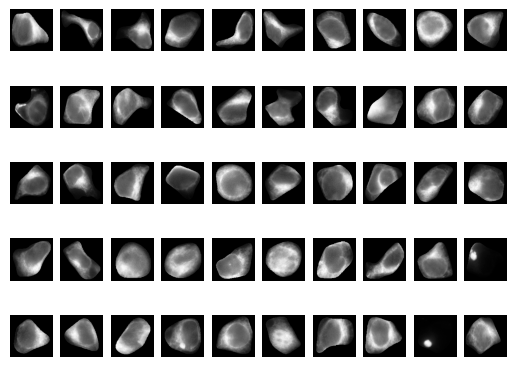

11it [00:13,  1.39s/it]

---------------------------------------
11 . mNG2_60_BCAP31_C_15


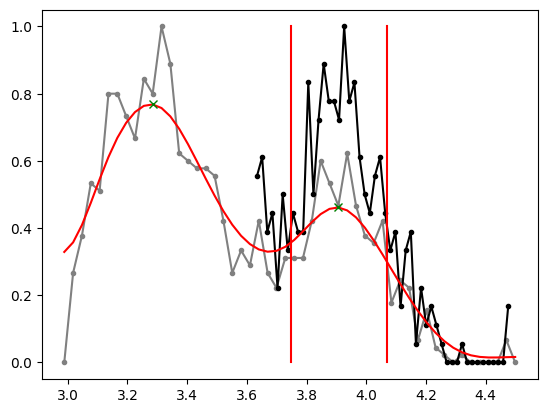

Cells: 220


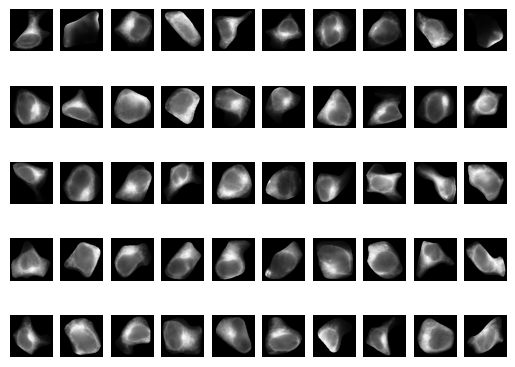

12it [00:14,  1.52s/it]

---------------------------------------
12 . mNG2_60_BCAP31_C_23


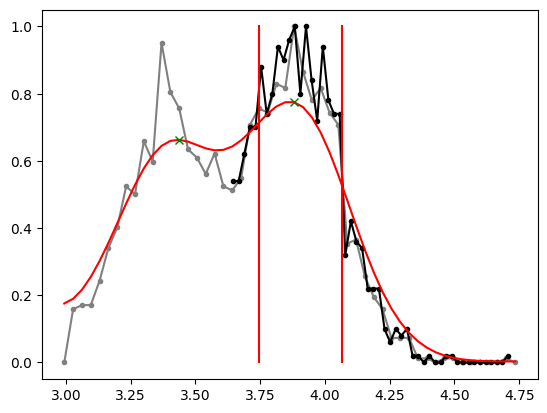

Cells: 635


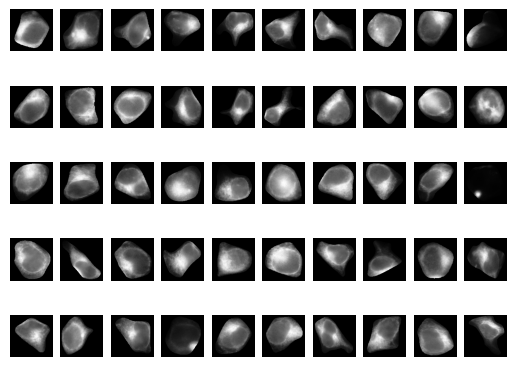

13it [00:16,  1.64s/it]

---------------------------------------
13 . mNG2_60_CAPZB_N_-30


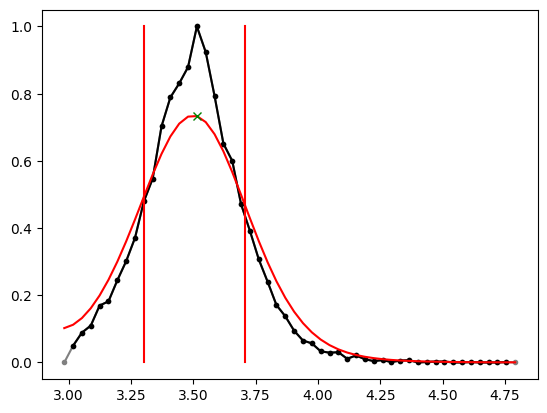

14it [00:16,  1.21s/it]

---------------------------------------
14 . mNG2_60_CCT3_N_-2


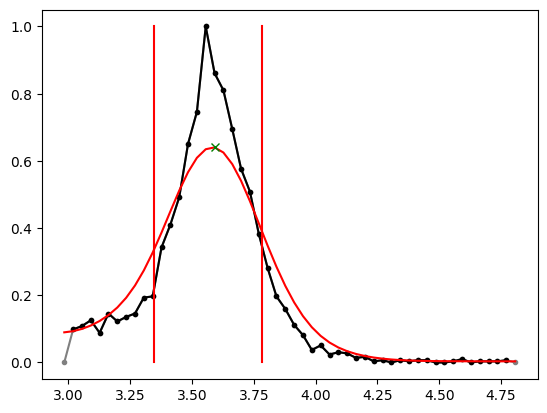

15it [00:17,  1.10it/s]

---------------------------------------
15 . mNG2_60_CCT3_N_-26


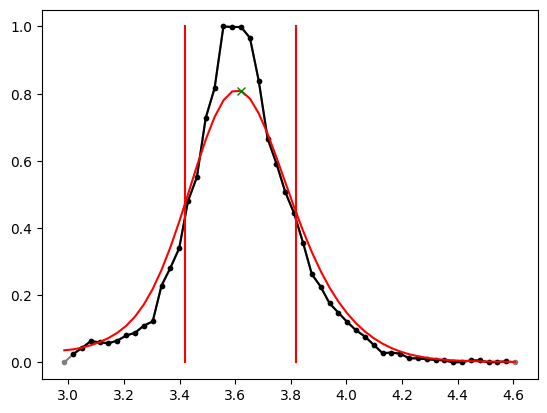

16it [00:17,  1.43it/s]

---------------------------------------
16 . mNG2_60_CCT3_N_1


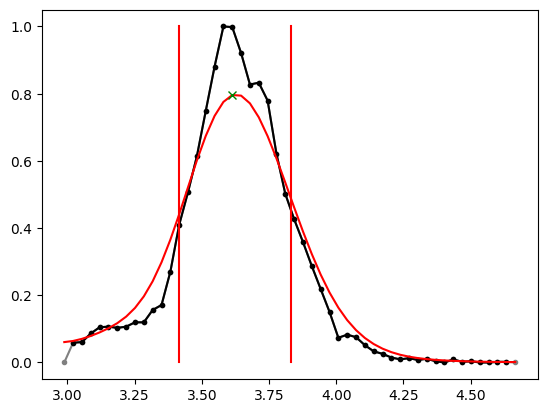

17it [00:17,  1.82it/s]

---------------------------------------
17 . mNG2_60_CCT3_N_18


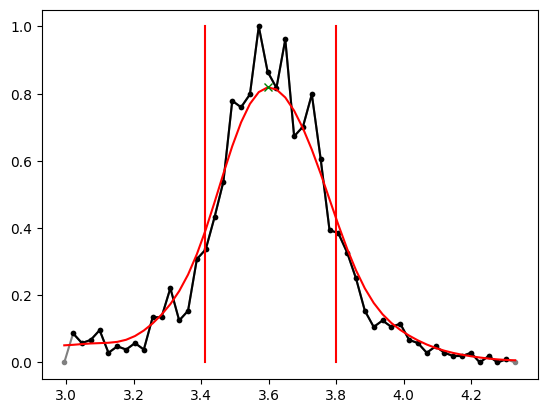

18it [00:17,  2.26it/s]

---------------------------------------
18 . mNG2_60_CENPM_C_-1


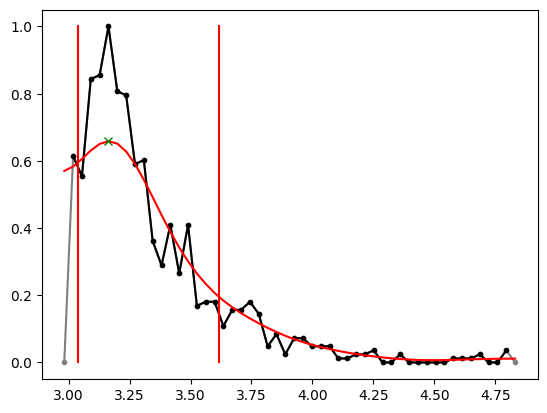

19it [00:18,  2.40it/s]

---------------------------------------
19 . mNG2_60_CENPM_C_-26


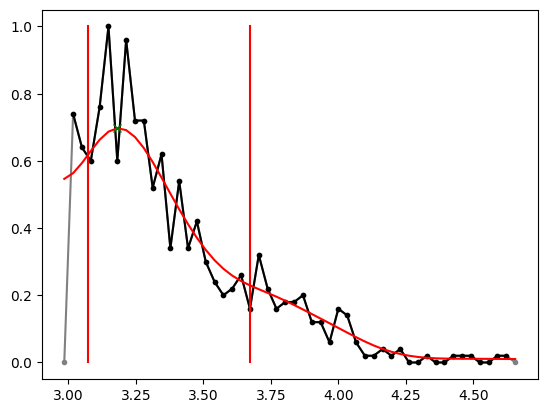

20it [00:18,  2.85it/s]

---------------------------------------
20 . mNG2_60_CHMP3_C_-1


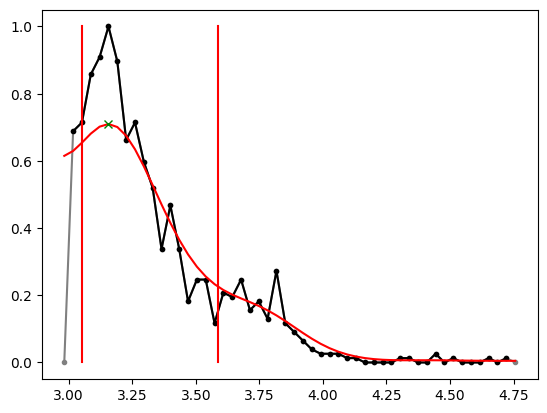

21it [00:18,  3.36it/s]

---------------------------------------
21 . mNG2_60_CLASP1_N_-5


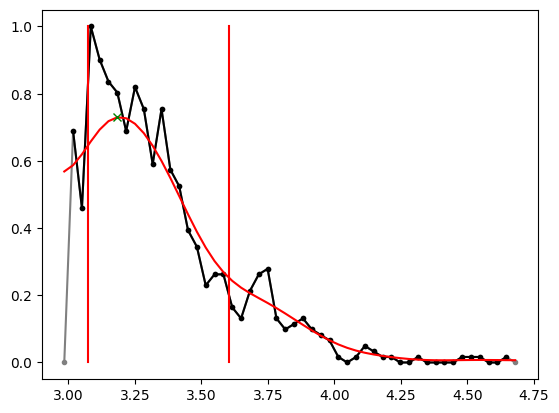

22it [00:18,  3.85it/s]

---------------------------------------
22 . mNG2_60_COPE_C_-1


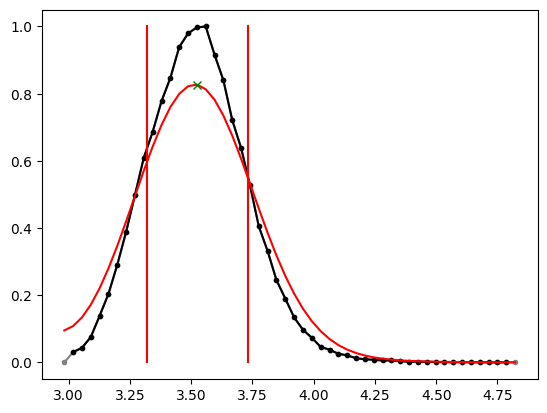

23it [00:18,  3.79it/s]

---------------------------------------
23 . mNG2_60_COPE_C_-29


24it [00:19,  4.20it/s]

---------------------------------------
24 . mNG2_60_COPE_C_16


25it [00:19,  4.59it/s]

---------------------------------------
25 . mNG2_60_CORO1B_C_-1


26it [00:19,  4.89it/s]

---------------------------------------
26 . mNG2_60_CSNK2A1_C_-16


27it [00:19,  4.98it/s]

---------------------------------------
27 . mNG2_60_CSNK2A1_C_0


28it [00:19,  5.24it/s]

---------------------------------------
28 . mNG2_60_CTNNBL1_C_-14


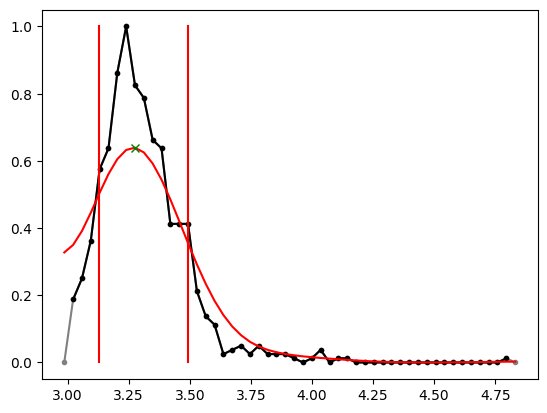

29it [00:20,  5.30it/s]

---------------------------------------
29 . mNG2_60_CTNNBL1_C_14


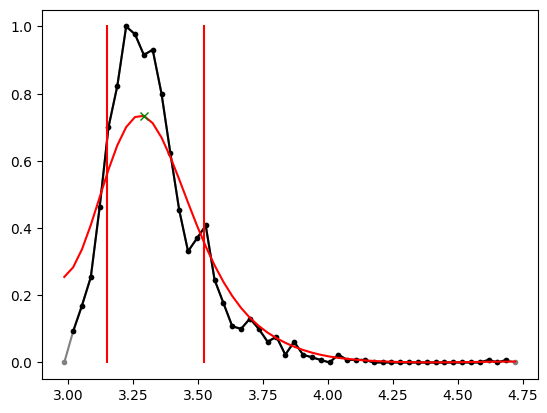

30it [00:20,  5.46it/s]

---------------------------------------
30 . mNG2_60_EIF4A3_N_-19


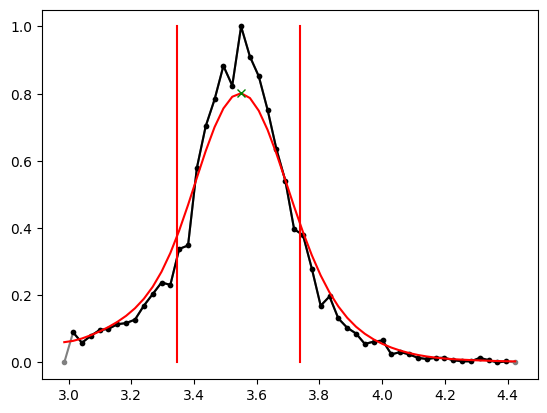

31it [00:20,  5.56it/s]

---------------------------------------
31 . mNG2_60_EIF4A3_N_-5


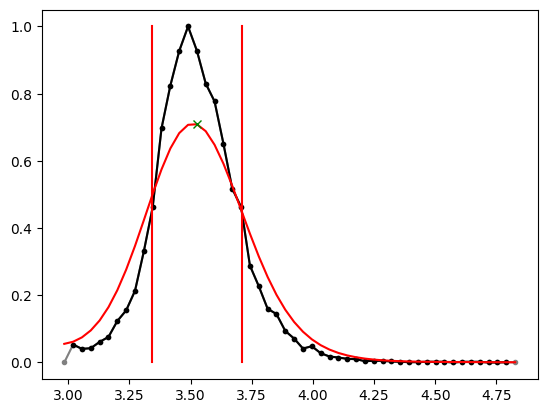

32it [00:20,  5.49it/s]

---------------------------------------
32 . mNG2_60_EIF4A3_N_10


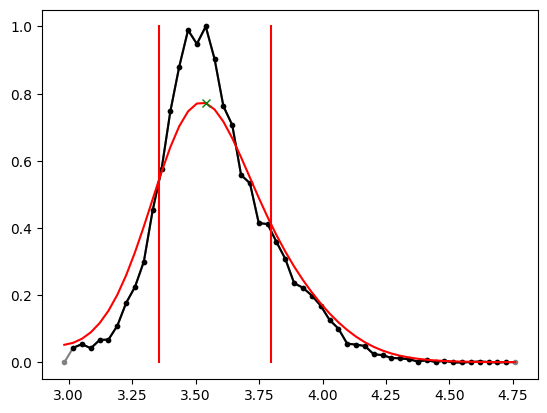

33it [00:20,  5.47it/s]

---------------------------------------
33 . mNG2_60_EIF4A3_N_28


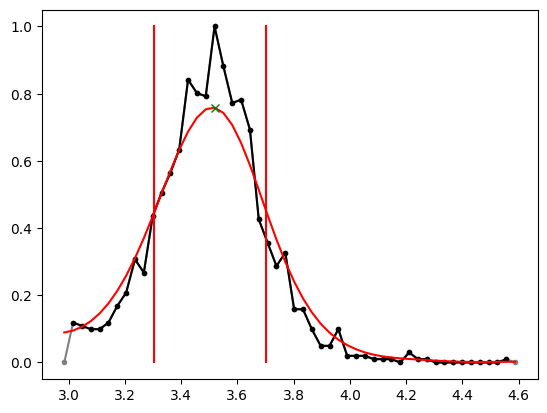

34it [00:20,  5.12it/s]

---------------------------------------
34 . mNG2_60_ELOVL1_C_-11


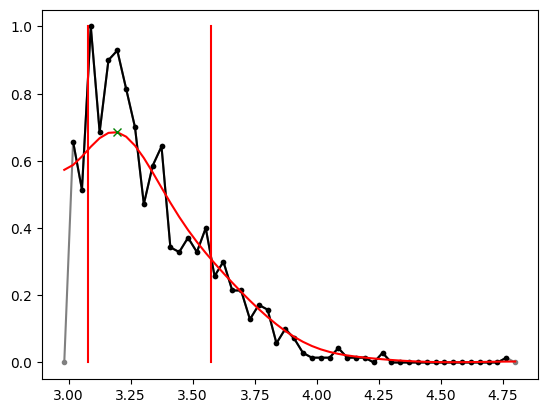

35it [00:21,  4.88it/s]

---------------------------------------
35 . mNG2_60_EMC4_N_-2


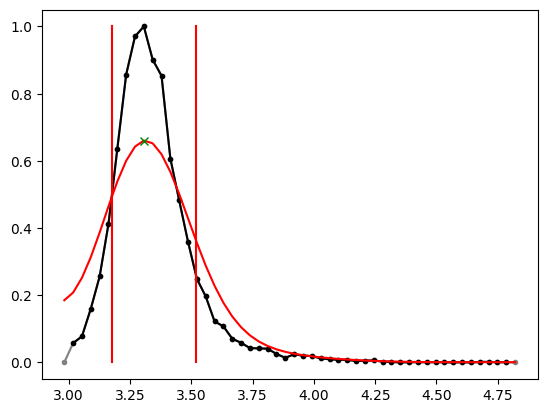

36it [00:21,  4.74it/s]

---------------------------------------
36 . mNG2_60_EMC4_N_-30


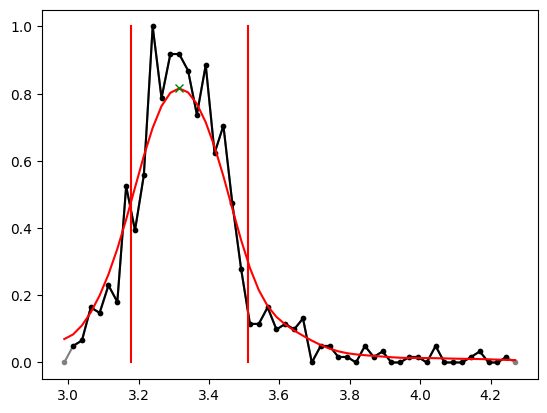

37it [00:21,  4.75it/s]

---------------------------------------
37 . mNG2_60_EMG1_N_-5


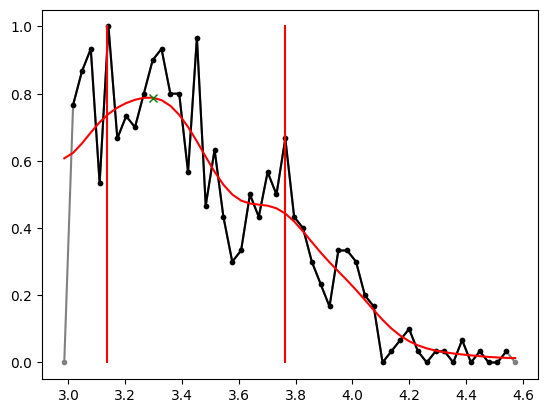

38it [00:21,  4.71it/s]

---------------------------------------
38 . mNG2_60_HDAC1_C_-29


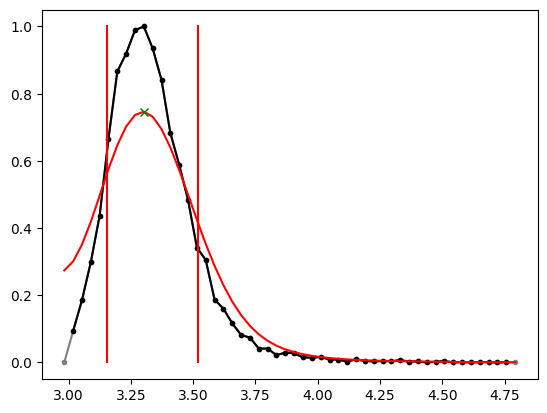

39it [00:22,  3.94it/s]

---------------------------------------
39 . mNG2_60_HDAC1_C_-8


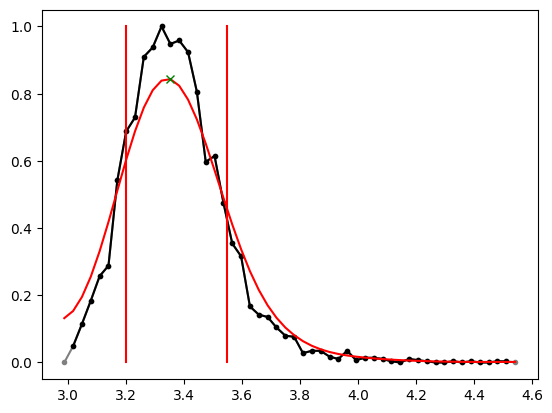

40it [00:22,  4.10it/s]

---------------------------------------
40 . mNG2_60_HMGA1_C_-14


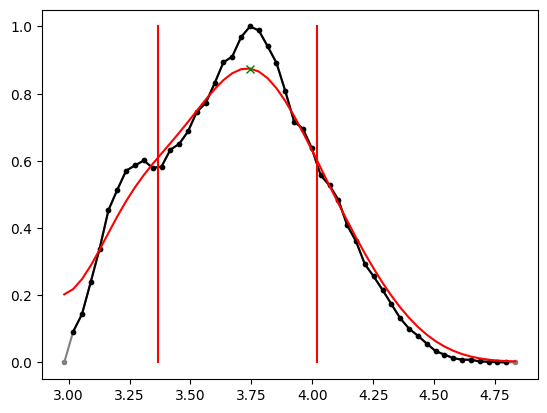

41it [00:22,  3.90it/s]

---------------------------------------
41 . mNG2_60_HMGA1_C_-17


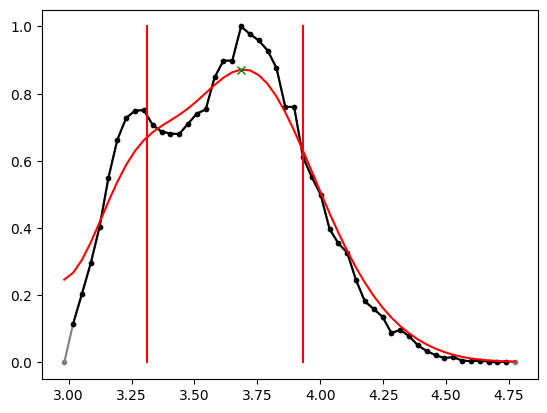

42it [00:22,  3.88it/s]

---------------------------------------
42 . mNG2_60_HMGA1_C_19


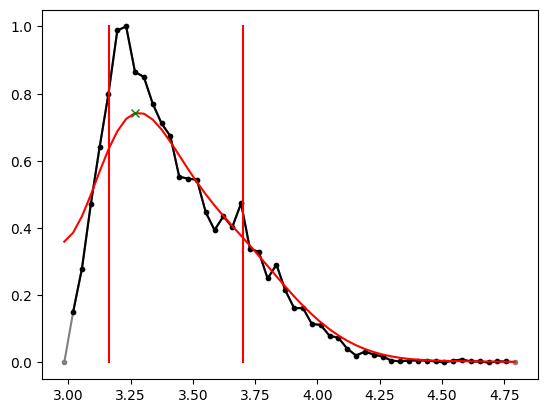

43it [00:23,  4.06it/s]

---------------------------------------
43 . mNG2_60_HSP90B1_N_-18


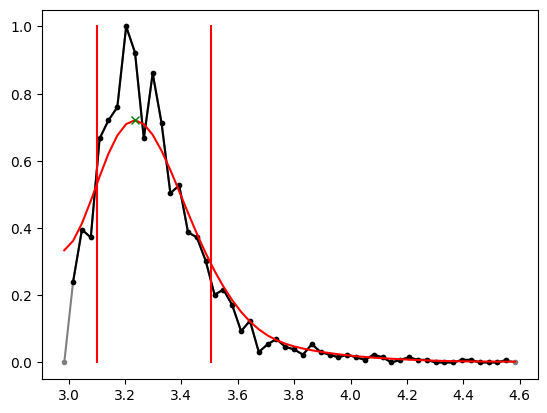

44it [00:23,  4.22it/s]

---------------------------------------
44 . mNG2_60_HSPBP1_C_-23


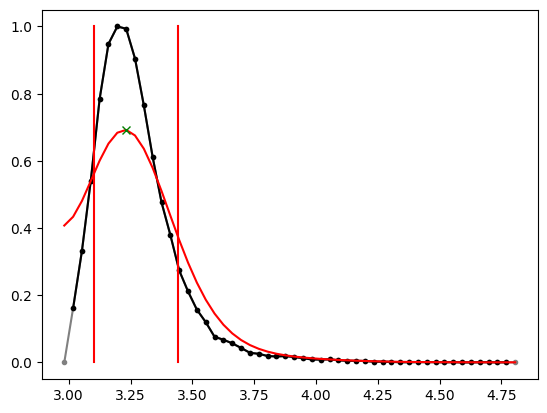

45it [00:23,  4.04it/s]

---------------------------------------
45 . mNG2_60_LAMTOR2_N_-10


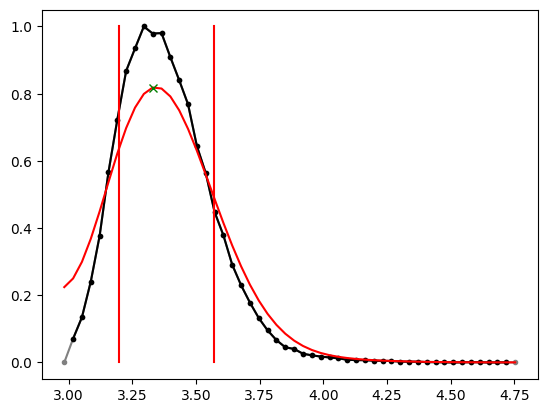

46it [00:23,  3.97it/s]

---------------------------------------
46 . mNG2_60_LAMTOR2_N_-19


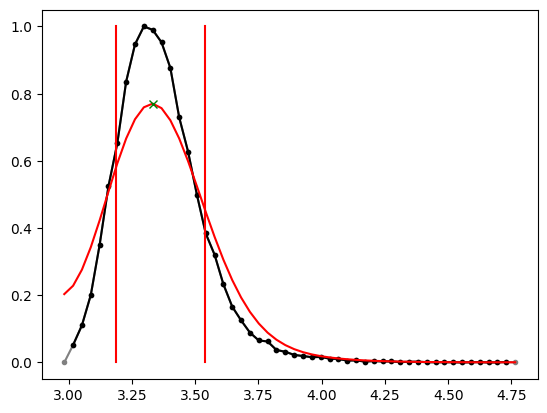

47it [00:24,  3.99it/s]

---------------------------------------
47 . mNG2_60_LPCAT2_N_8


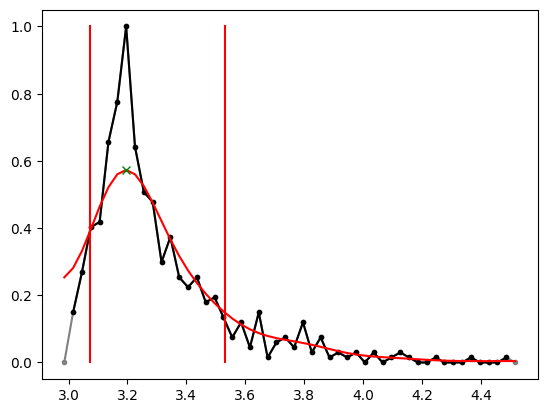

48it [00:24,  4.25it/s]

---------------------------------------
48 . mNG2_60_MED14_N_-5


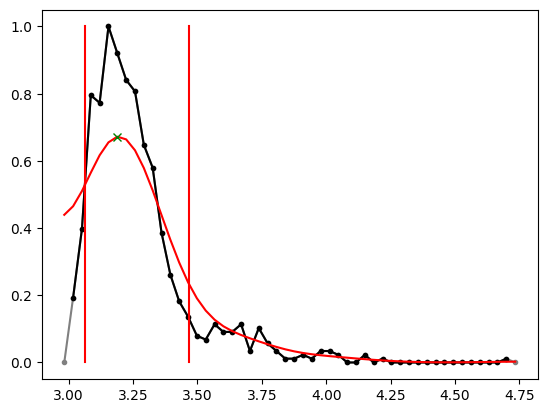

49it [00:24,  4.44it/s]

---------------------------------------
49 . mNG2_60_MYO19_N_-9


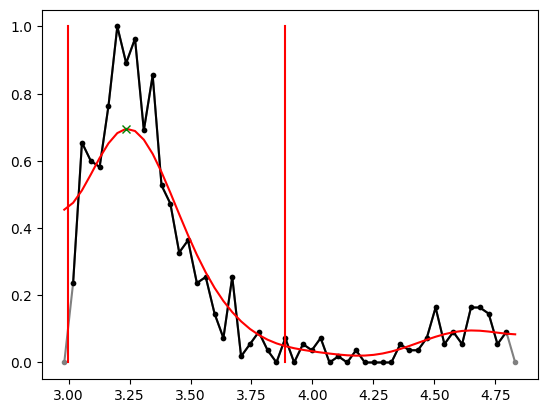

50it [00:24,  4.53it/s]

---------------------------------------
50 . mNG2_60_NUP153_N_7


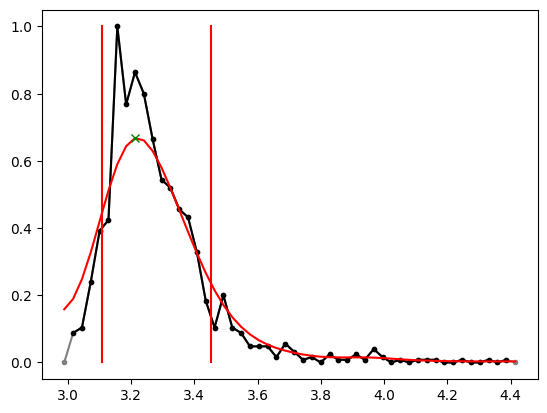

51it [00:25,  4.66it/s]

---------------------------------------
51 . mNG2_60_PI4KB_N_-11


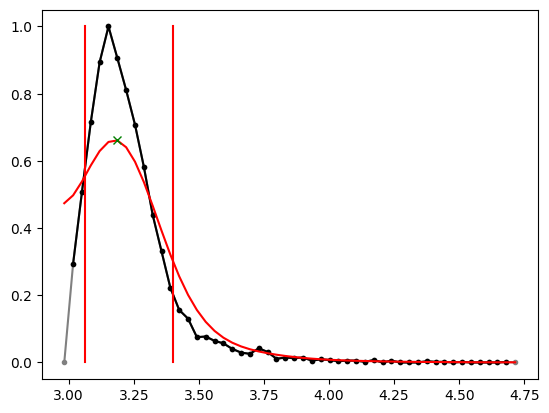

52it [00:25,  4.71it/s]

---------------------------------------
52 . mNG2_60_PMVK_N_-16


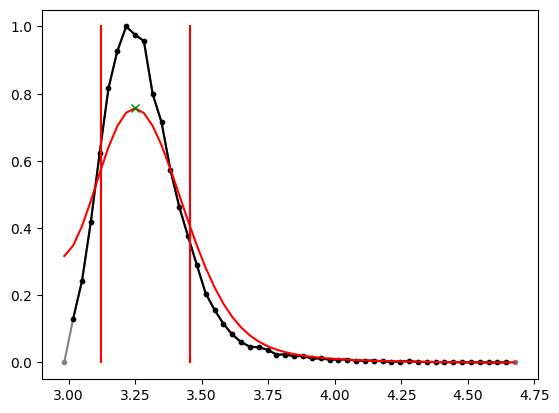

53it [00:25,  4.48it/s]

---------------------------------------
53 . mNG2_60_PMVK_N_-5


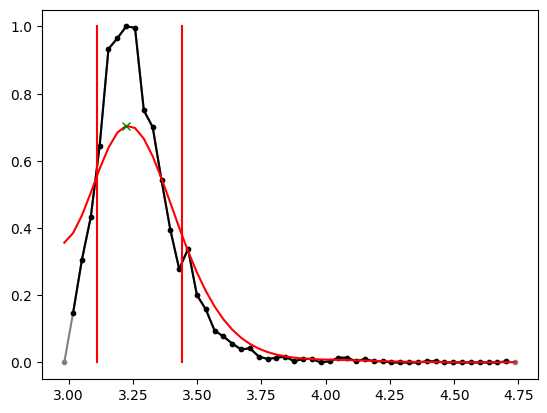

54it [00:25,  4.48it/s]

---------------------------------------
54 . mNG2_60_PMVK_N_22


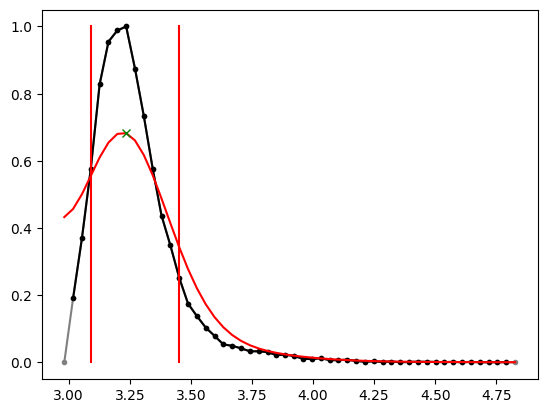

55it [00:25,  4.64it/s]

---------------------------------------
55 . mNG2_60_POLR2K_N_-17


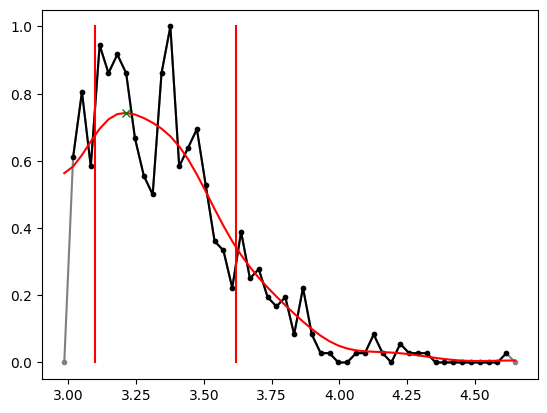

56it [00:26,  4.74it/s]

---------------------------------------
56 . mNG2_60_POLR2K_N_-5


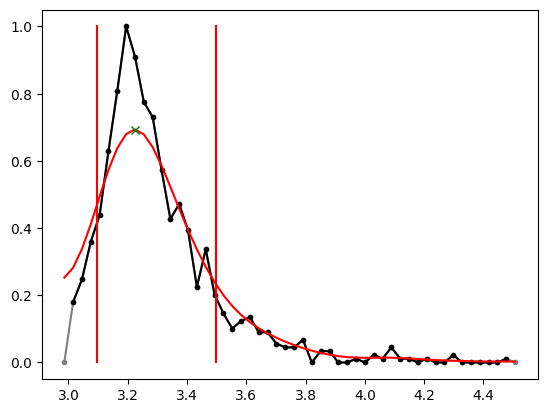

57it [00:26,  4.67it/s]

---------------------------------------
57 . mNG2_60_PSMF1_C_0


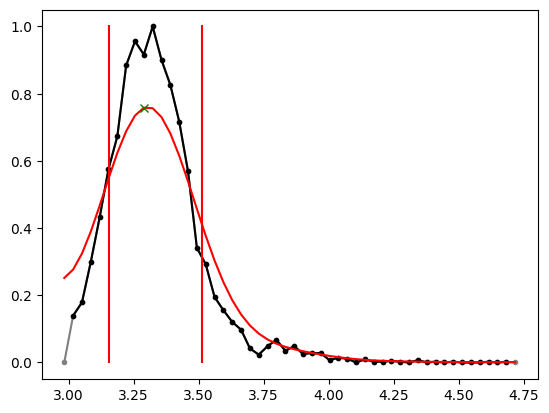

58it [00:26,  4.68it/s]

---------------------------------------
58 . mNG2_60_RAB3GAP2_N_-13


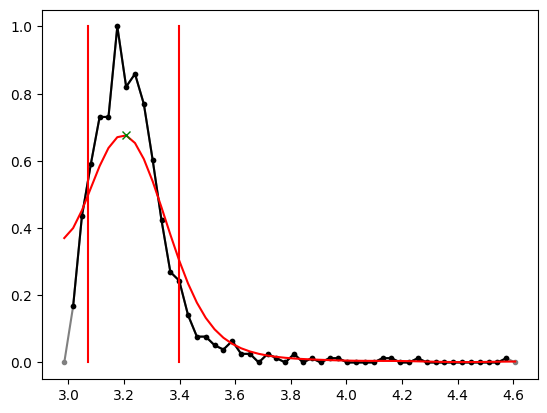

59it [00:26,  4.15it/s]

---------------------------------------
59 . mNG2_60_RAB3GAP2_N_-22


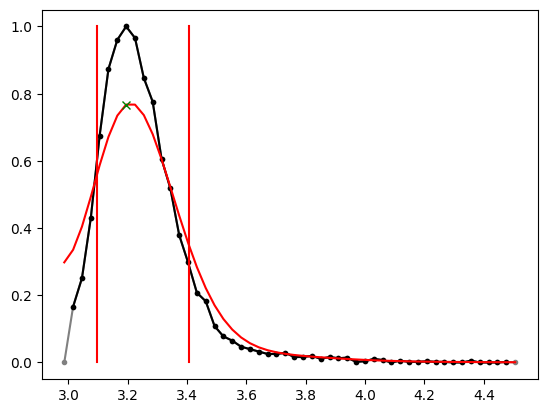

60it [00:27,  4.35it/s]

---------------------------------------
60 . mNG2_60_RAB3GAP2_N_13


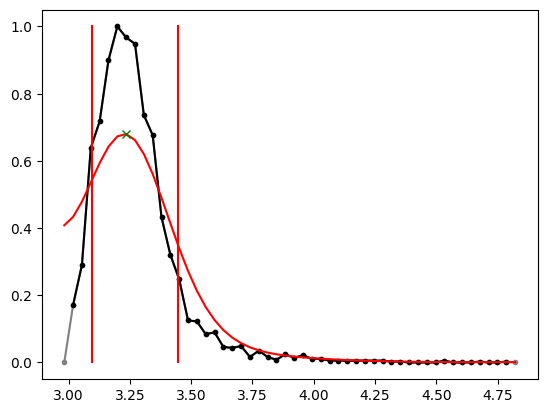

61it [00:27,  4.38it/s]

---------------------------------------
61 . mNG2_60_RBM10_C_-11


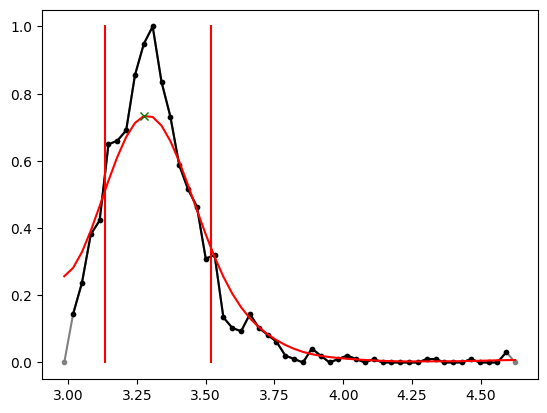

62it [00:27,  4.47it/s]

---------------------------------------
62 . mNG2_60_RBM10_C_-29


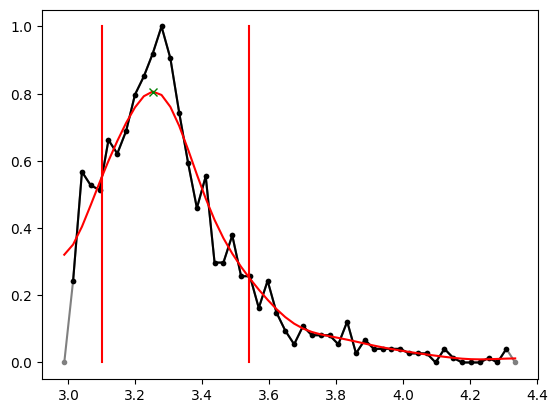

63it [00:27,  4.55it/s]

---------------------------------------
63 . mNG2_60_RIOK2_N_-15


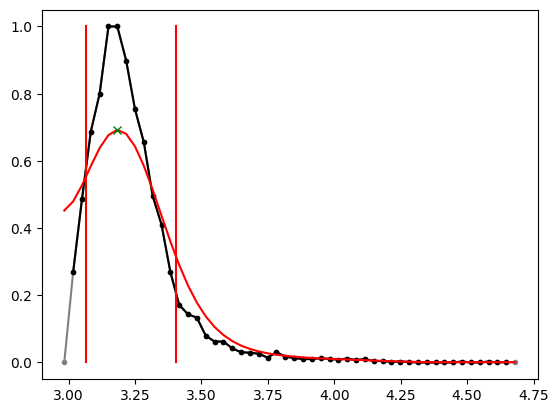

64it [00:27,  4.42it/s]

---------------------------------------
64 . mNG2_60_RIOK2_N_-16


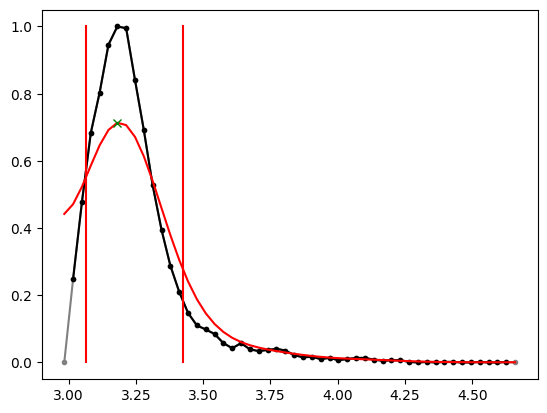

65it [00:28,  4.46it/s]

---------------------------------------
65 . mNG2_60_RIOK2_N_1


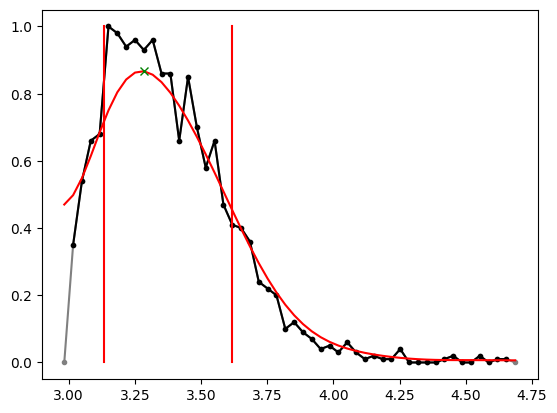

66it [00:28,  4.49it/s]

---------------------------------------
66 . mNG2_60_SCAMP2_C_-22


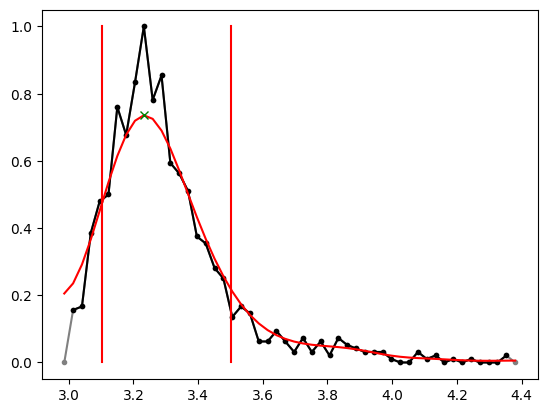

67it [00:28,  4.52it/s]

---------------------------------------
67 . mNG2_60_SCAMP2_C_13


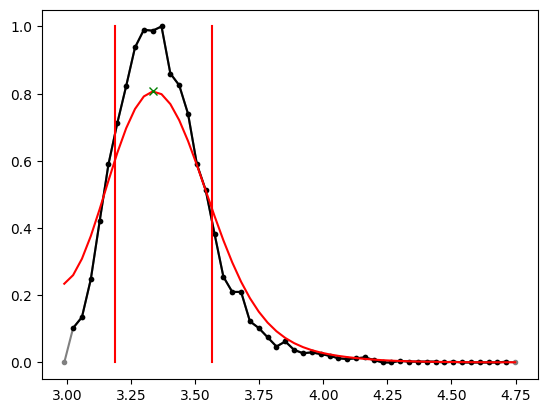

68it [00:28,  4.53it/s]

---------------------------------------
68 . mNG2_60_SCAMP4_C_0


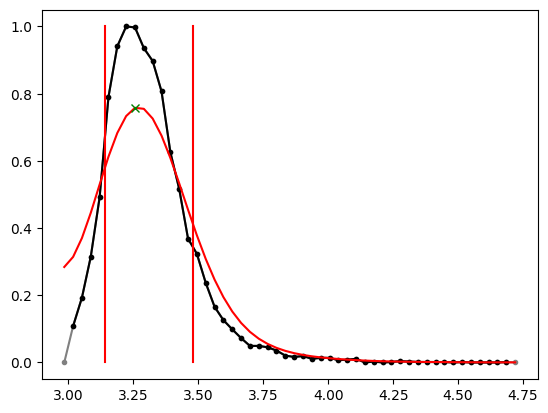

69it [00:29,  4.40it/s]

---------------------------------------
69 . mNG2_60_SEPTIN9_C_-11


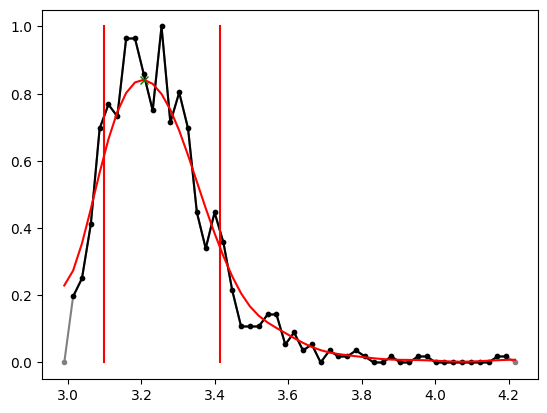

70it [00:29,  4.49it/s]

---------------------------------------
70 . mNG2_60_SLC7A5_C_-11


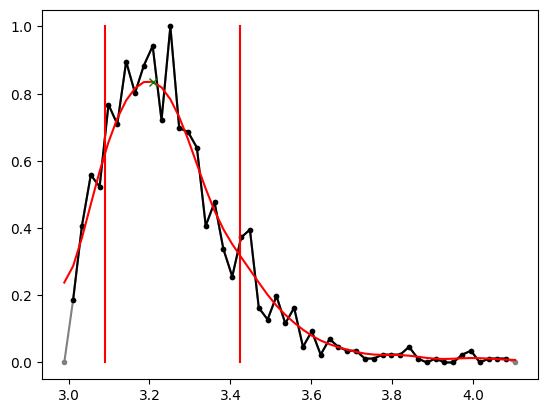

71it [00:29,  4.57it/s]

---------------------------------------
71 . mNG2_60_SLC7A5_C_-23


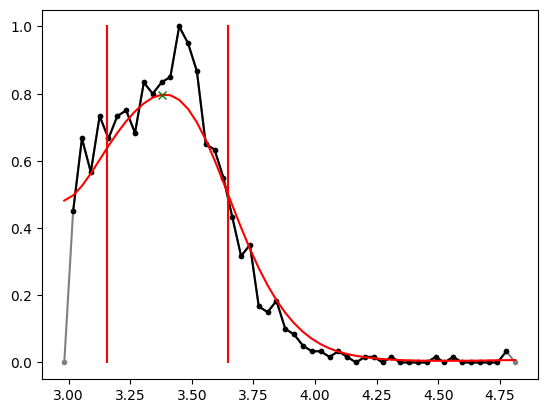

72it [00:29,  4.58it/s]

---------------------------------------
72 . mNG2_60_SMARCB1_C_-11


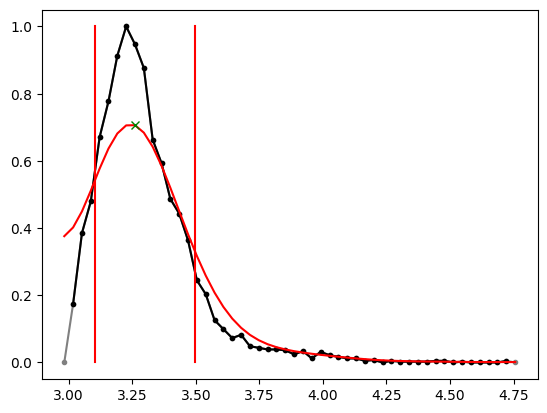

73it [00:29,  4.56it/s]

---------------------------------------
73 . mNG2_60_SMARCB1_C_-17


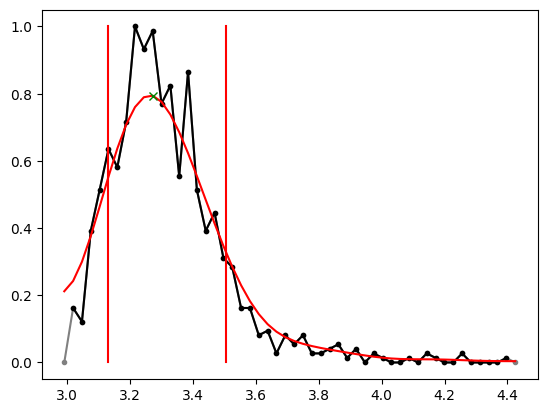

74it [00:30,  4.57it/s]

---------------------------------------
74 . mNG2_60_SPNS1_N_-30


75it [00:30,  4.56it/s]

---------------------------------------
75 . mNG2_60_SPNS1_N_-5


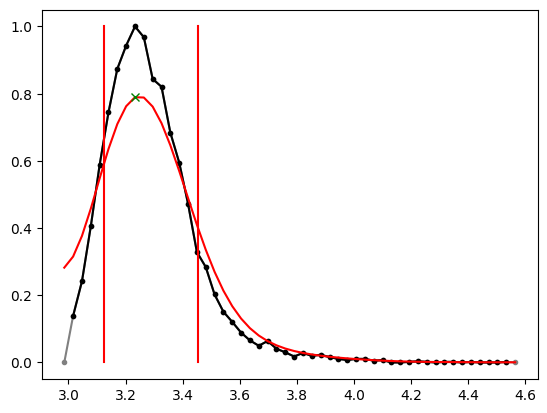

76it [00:30,  4.52it/s]

---------------------------------------
76 . mNG2_60_SPNS1_N_29


77it [00:30,  4.53it/s]

---------------------------------------
77 . mNG2_60_SPOUT1_C_-12


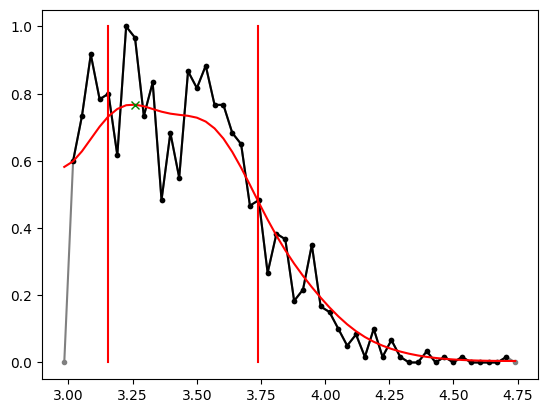

78it [00:31,  4.54it/s]

---------------------------------------
78 . mNG2_60_STT3B_N_-15


79it [00:31,  4.08it/s]

---------------------------------------
79 . mNG2_60_STT3B_N_-17


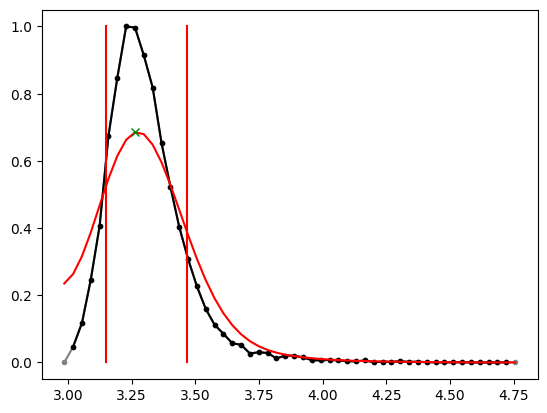

80it [00:31,  4.34it/s]

---------------------------------------
80 . mNG2_60_STT3B_N_13


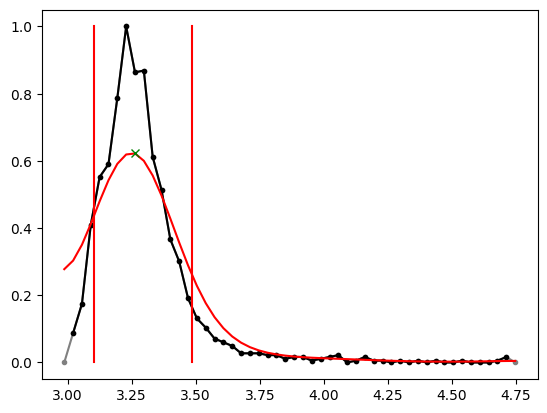

81it [00:31,  4.65it/s]

---------------------------------------
81 . mNG2_60_STT3B_N_19


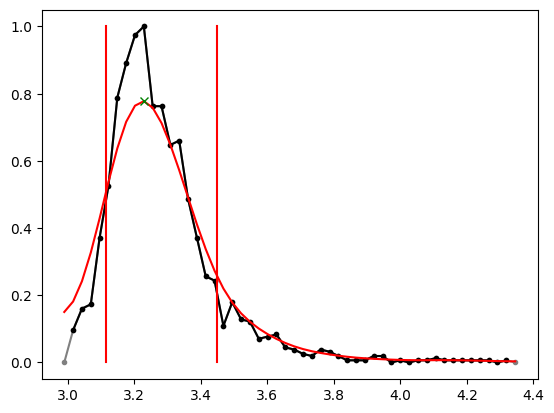

82it [00:31,  4.92it/s]

---------------------------------------
82 . mNG2_60_STX8_N_-22


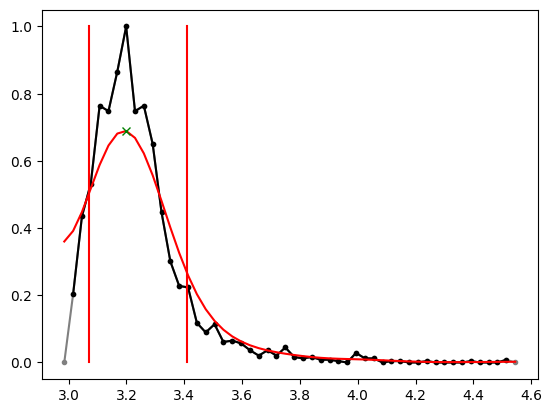

83it [00:32,  5.10it/s]

---------------------------------------
83 . mNG2_60_TERF2_N_-29


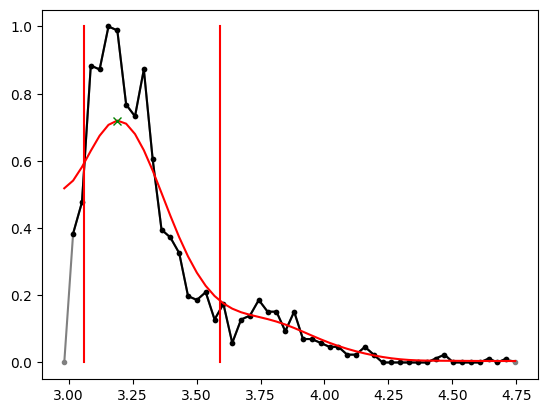

84it [00:32,  5.24it/s]

---------------------------------------
84 . mNG2_60_TUBG1_N_0


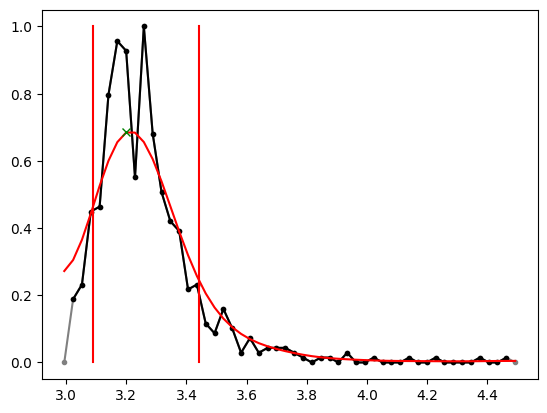

85it [00:32,  5.38it/s]

---------------------------------------
85 . mNG2_60_VCP_N_-27


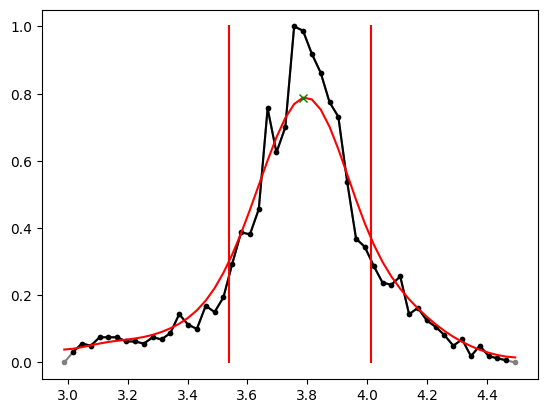

86it [00:32,  5.46it/s]

---------------------------------------
86 . mNG2_60_VCP_N_1


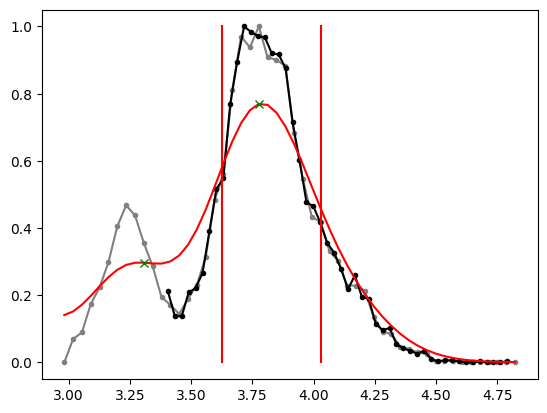

Cells: 3528


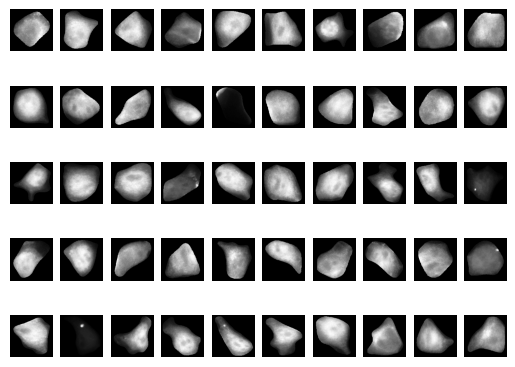

87it [00:35,  1.14it/s]

---------------------------------------
87 . mNG2_60_YWHAH_C_-10


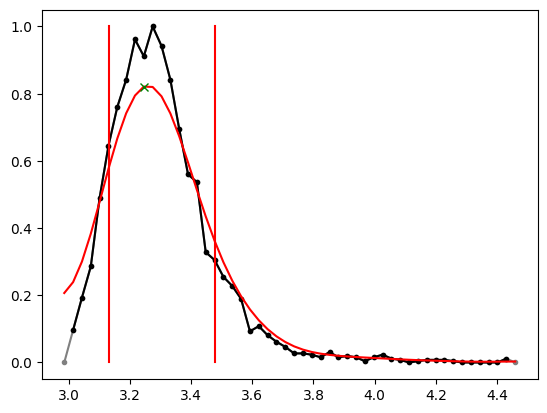

88it [00:35,  1.49it/s]

---------------------------------------
88 . mNG2_60_YWHAQ_C_-15


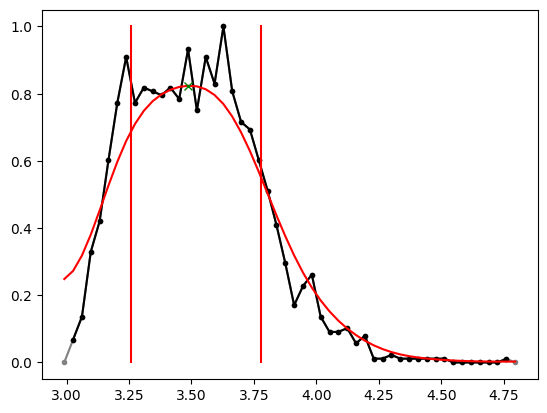

89it [00:35,  1.91it/s]

---------------------------------------
89 . mNG2_60_YWHAQ_C_-23


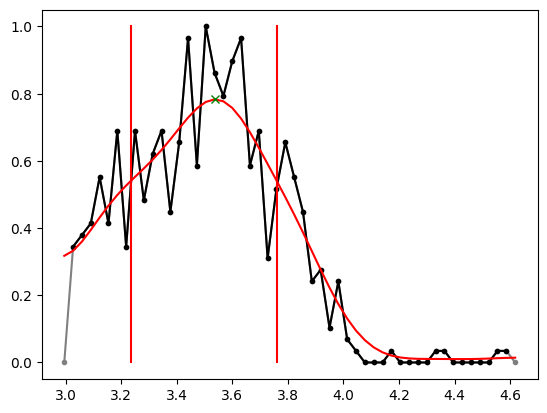

90it [00:35,  2.34it/s]

---------------------------------------
90 . mNG2_60_ZNF326_N_-24


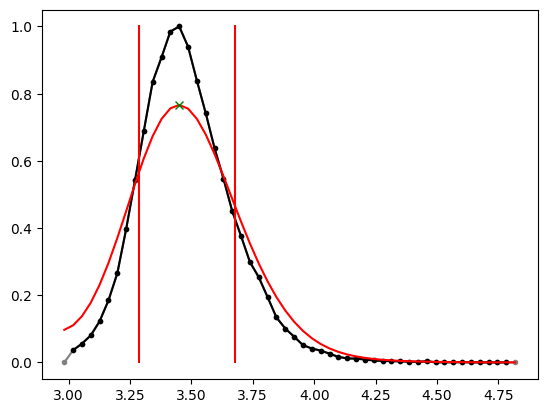

91it [00:35,  2.75it/s]

---------------------------------------
91 . mNG2_60_ZNF326_N_1


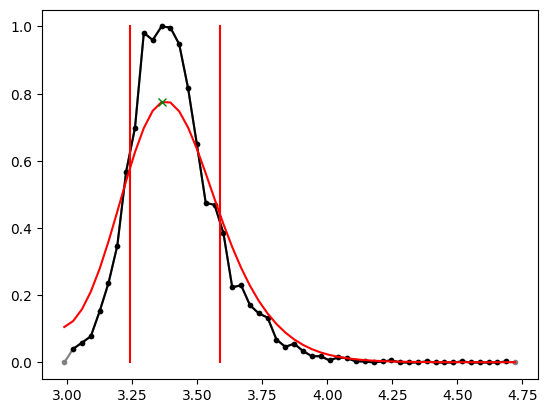

92it [00:36,  3.23it/s]

---------------------------------------
92 . mNG2_60_ZNF326_N_29


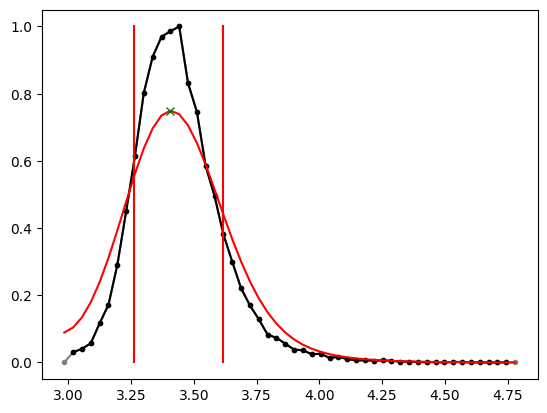

93it [00:36,  2.55it/s]


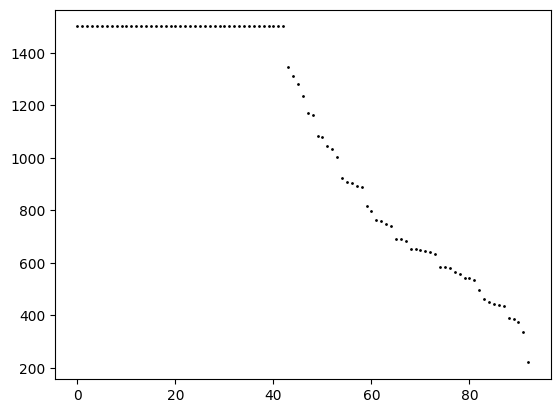

Master: (101231, 38)
(2172, 38)
(102731, 38)


In [5]:
path_name = 'single_cells'

Max_Cells = 1500

df_counts_lenti = df['sgRNA'].value_counts().reset_index()
df_counts_lenti = df_counts_lenti[df_counts_lenti['count'] >= 513].sort_values(by='sgRNA')

df_master = pd.DataFrame(np.empty([0, len(df.columns)]), columns=df.columns)

for g, sgRNA in tqdm(enumerate(df_counts_lenti['sgRNA'])):
    
    print('---------------------------------------')
    print(g, '.', sgRNA)
    
    gene = sgRNA.split('_')[2]
    df_sgRNA = df[df['sgRNA'] == sgRNA]
    Z = np.log10(df_sgRNA['ints_avg_GFP_300'])
    
    _, peaks = Find_Intensity_Peaks(Z, verbose=False)
    
    if len(peaks) == 1:
        mark = 1
        
        pick_range, _ = Find_Intensity_Peaks(Z, verbose=True)
        df_album = df_sgRNA.copy()
        df_album = df_album[df_album['ints_avg_GFP_300'] >= 10**pick_range[0]]
        df_album = df_album[df_album['ints_avg_GFP_300'] <= 10**pick_range[1]]
        df_add = df_album.copy()
    
    if len(peaks) > 1:

            pick_range, _ = Find_Intensity_Peaks(Z, peak_choice=-1, verbose=True)
            df_album = df_sgRNA.copy()
            df_album = df_album[df_album['ints_avg_GFP_300'] >= 10**pick_range[0]]
            df_album = df_album[df_album['ints_avg_GFP_300'] <= 10**pick_range[1]]
            df_add = df_album.copy()
            Make_Album_50(df_sgRNA, 'ints_avg_GFP_300', pick_range, path_name)
            plt.show()
        
    else:
        print('Skip')
    
    if len(df_add) > Max_Cells:
        df_add = df_add.sample(n=Max_Cells)
    
    df_master = pd.concat((df_master, df_add))
    # print(g, sgRNA, mark, df_add.shape)

counts = df_master['sgRNA'].value_counts()
plt.scatter(range(len(counts)), counts.to_numpy(), s=1, c='black')
plt.show()
print('Master:', df_master.shape)

# Add NTC cells
print(df_NTC.shape)
df_NTC_sub = df_NTC.sample(n=Max_Cells)
df_master = pd.concat((df_master, df_NTC_sub))
print(df_master.shape)

In [6]:
df_locals = pd.read_csv('20230418_PE_library_localizations.csv')

print(df_master.shape)
data = np.empty([len(df_master)], dtype=object)
for i in tqdm(range(len(df_master))):
    idx = np.where(df_master['gene'].iloc[i] == df_locals['Gene'])[0][0]
    data[i] = df_locals['annotations'].iloc[int(np.squeeze(idx))]
        
df_master['local'] = data
print(df_master.shape)
print(np.unique(df_master['local'].to_numpy().astype(str)))

(102731, 38)


100%|██████████| 102731/102731 [00:10<00:00, 9945.61it/s] 


(102731, 39)
['CEL' 'CNT' 'CYS' 'CYT' 'ER' 'GOL' 'MIT' 'NSK' 'NTC' 'NUC' 'NUCB' 'NUCI'
 'NUCM' 'VSC']


In [7]:
path_name = 'single_cells'

H = 128
W = 128

img_data = np.zeros([len(df_master), 3, H, W])
for i, file in tqdm(enumerate(df_master['image'])):
    img_data[i] = np.moveaxis(np.array(Image.open(os.path.join(path_name, file)).resize((H, W)), dtype=float), -1, 0)[:-1]

np.save('data_1500cpg.npy', img_data)
df_master.to_csv('labels_1500cpg.csv', index=False)

print(img_data.shape, df_master.shape)

102731it [04:18, 397.03it/s]


(102731, 3, 128, 128) (102731, 39)
